In [0]:
import sys
import numpy as np
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.datasets import mnist
from random import randint
import matplotlib.pyplot as plt

In [0]:
class Discriminator(object):
    def __init__(self, width = 28, height= 28, channels = 1, latent_size=100):
        self.CAPACITY = width*height*channels
        self.SHAPE = (width,height,channels)
        self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)


        self.Discriminator = self.model()
        self.Discriminator.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER, metrics=['accuracy'] )
        self.summary()

    def model(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.SHAPE))
        model.add(Dense(self.CAPACITY, input_shape=self.SHAPE))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(int(self.CAPACITY/2)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        return model

    def summary(self):
        return self.Discriminator.summary()


In [0]:
class Generator(object):
    def __init__(self, width = 28, height= 28, channels = 1, latent_size=100):
        self.W = width
        self.H = height
        self.C = channels
        self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)

        self.LATENT_SPACE_SIZE = latent_size
        self.latent_space = np.random.normal(0,1,(self.LATENT_SPACE_SIZE,))

        self.Generator = self.model()
        self.Generator.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)
        self.summary()

    def model(self, block_starting_size=128,num_blocks=4):
        model = Sequential()
        
        block_size = block_starting_size 
        model.add(Dense(block_size, input_shape=(self.LATENT_SPACE_SIZE,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        for i in range(num_blocks-1):
            block_size = block_size * 2
            model.add(Dense(block_size))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.W * self.H * self.C, activation='tanh'))
        model.add(Reshape((self.W, self.H, self.C)))
        
        return model

    def summary(self):
        return self.Generator.summary()


In [0]:
class GAN(object):
    def __init__(self,discriminator,generator):
        self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)
        
        self.Generator = generator

        self.Discriminator = discriminator
        self.Discriminator.trainable = False
        
        self.gan_model = self.model()
        self.gan_model.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)
        self.summary()

    def model(self):
        model = Sequential()
        model.add(self.Generator)
        model.add(self.Discriminator)
        return model

    def summary(self):
        return self.gan_model.summary()



In [0]:
class Trainer:
    def __init__(self, width = 28, height= 28, channels = 1, latent_size=100, epochs =50000, batch=32, checkpoint=50,model_type=-1):
        self.W = width
        self.H = height
        self.C = channels
        self.EPOCHS = epochs
        self.BATCH = batch
        self.CHECKPOINT = checkpoint
        self.model_type=model_type

        self.LATENT_SPACE_SIZE = latent_size

        self.generator = Generator(height=self.H, width=self.W, channels=self.C, latent_size=self.LATENT_SPACE_SIZE)
        self.discriminator = Discriminator(height=self.H, width=self.W, channels=self.C)
        self.gan = GAN(generator=self.generator.Generator, discriminator=self.discriminator.Discriminator)

        self.load_MNIST()

    def load_MNIST(self,model_type=3):
        allowed_types = [-1,0,1,2,3,4,5,6,7,8,9]
        if self.model_type not in allowed_types:
            print('ERROR: Only Integer Values from -1 to 9 are allowed')

        (self.X_train, self.Y_train), (_, _) = mnist.load_data()
        if self.model_type!=-1:
            self.X_train = self.X_train[np.where(self.Y_train==int(self.model_type))[0]]
        
        # Rescale -1 to 1
        # Find Normalize Function from CV Class  
        self.X_train = ( np.float32(self.X_train) - 127.5) / 127.5
        self.X_train = np.expand_dims(self.X_train, axis=3)
        return

    def train(self):
        for e in range(self.EPOCHS):
            # Train Discriminator
            # Make the training batch for this model be half real, half noise
            # Grab Real Images for this training batch
            count_real_images = int(self.BATCH/2)
            starting_index = randint(0, (len(self.X_train)-count_real_images))
            real_images_raw = self.X_train[ starting_index : (starting_index + count_real_images) ]
            x_real_images = real_images_raw.reshape( count_real_images, self.W, self.H, self.C )
            y_real_labels = np.ones([count_real_images,1])

            # Grab Generated Images for this training batch
            latent_space_samples = self.sample_latent_space(count_real_images)
            x_generated_images = self.generator.Generator.predict(latent_space_samples)
            y_generated_labels = np.zeros([self.BATCH-count_real_images,1])

            # Combine to train on the discriminator
            x_batch = np.concatenate( [x_real_images, x_generated_images] )
            y_batch = np.concatenate( [y_real_labels, y_generated_labels] )

            # Now, train the discriminator with this batch
            discriminator_loss = self.discriminator.Discriminator.train_on_batch(x_batch,y_batch)[0]
        
            # Generate Noise
            x_latent_space_samples = self.sample_latent_space(self.BATCH)
            y_generated_labels = np.ones([self.BATCH,1])
            generator_loss = self.gan.gan_model.train_on_batch(x_latent_space_samples,y_generated_labels)
            
            if e % self.CHECKPOINT == 0 :
              print ('Epoch: '+str(int(e))+', [Discriminator :: Loss: '+str(discriminator_loss)+'], [ Generator :: Loss: '+str(generator_loss)+']')
              self.plot_checkpoint(e)
                        
        return

    def sample_latent_space(self, instances):
        return np.random.normal(0, 1, (instances,self.LATENT_SPACE_SIZE))

    def plot_checkpoint(self,e):
        noise = self.sample_latent_space(16)
        images = self.generator.Generator.predict(noise)
        
        plt.figure(figsize=(4,4))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.H,self.W])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
#         plt.close('all')
        return

In [0]:
# Command Line Argument Method
HEIGHT  = 28
WIDTH   = 28
CHANNEL = 1
LATENT_SPACE_SIZE = 100
EPOCHS = 5000
BATCH = 32
CHECKPOINT = 100
MODEL_TYPE = 0

In [0]:
trainer = Trainer(height=HEIGHT,\
                 width=WIDTH,\
                 channels=CHANNEL,\
                 latent_size=LATENT_SPACE_SIZE,\
                 epochs =EPOCHS,\
                 batch=BATCH,\
                 checkpoint=CHECKPOINT,
                 model_type=MODEL_TYPE)
                 


Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_70 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 128)               512       
_________________________________________________________________
dense_93 (Dense)             (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_71 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 256)               1024      
_________________________________________________________________
dense_94 (Dense)             (None, 512)             

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0, [Discriminator :: Loss: 0.947194], [ Generator :: Loss: 0.80844474]


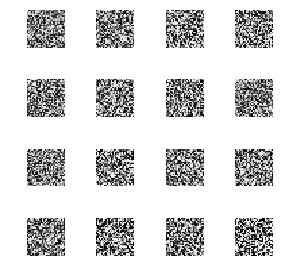

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 100, [Discriminator :: Loss: 0.009887127], [ Generator :: Loss: 4.879319]


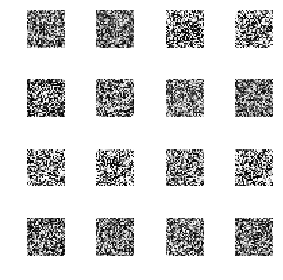

Epoch: 200, [Discriminator :: Loss: 0.027342247], [ Generator :: Loss: 4.893852]


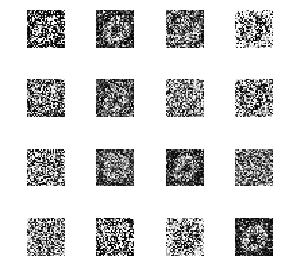

Epoch: 300, [Discriminator :: Loss: 0.08985031], [ Generator :: Loss: 6.744076]


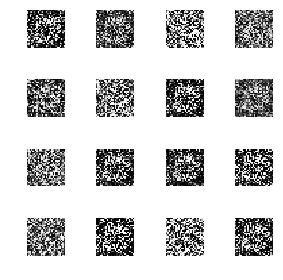

Epoch: 400, [Discriminator :: Loss: 0.047194853], [ Generator :: Loss: 7.1484394]


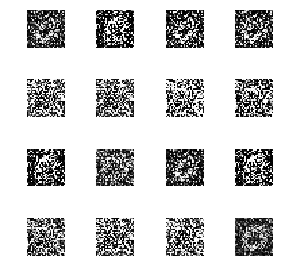

Epoch: 500, [Discriminator :: Loss: 0.12616345], [ Generator :: Loss: 9.650415]


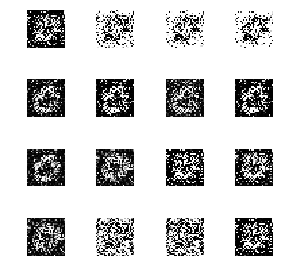

Epoch: 600, [Discriminator :: Loss: 0.00955902], [ Generator :: Loss: 9.879648]


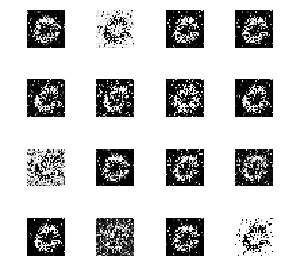

Epoch: 700, [Discriminator :: Loss: 0.08982249], [ Generator :: Loss: 7.6643753]


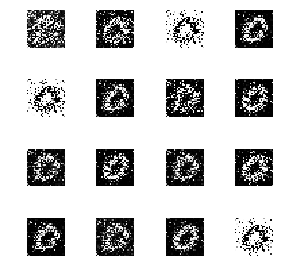

Epoch: 800, [Discriminator :: Loss: 0.093857005], [ Generator :: Loss: 7.534765]


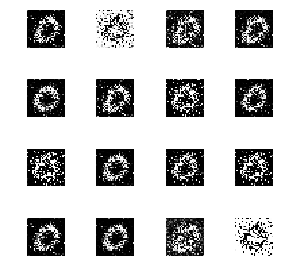

Epoch: 900, [Discriminator :: Loss: 0.15360674], [ Generator :: Loss: 11.142624]


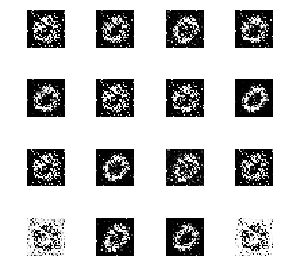

Epoch: 1000, [Discriminator :: Loss: 0.0068984157], [ Generator :: Loss: 10.343943]


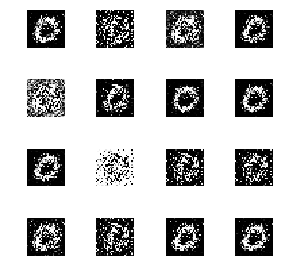

Epoch: 1100, [Discriminator :: Loss: 0.03196497], [ Generator :: Loss: 9.934107]


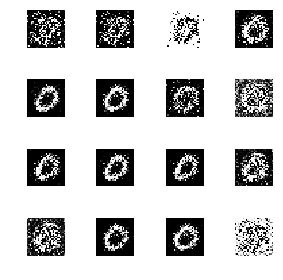

Epoch: 1200, [Discriminator :: Loss: 0.03963641], [ Generator :: Loss: 13.126033]


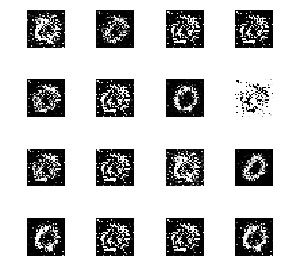

Epoch: 1300, [Discriminator :: Loss: 0.088431925], [ Generator :: Loss: 8.596151]


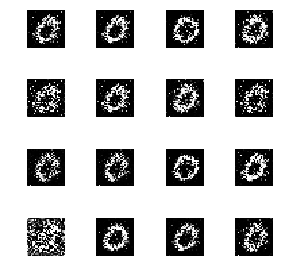

Epoch: 1400, [Discriminator :: Loss: 0.026170792], [ Generator :: Loss: 8.639069]


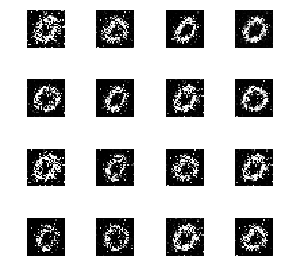

Epoch: 1500, [Discriminator :: Loss: 0.02690766], [ Generator :: Loss: 4.341988]


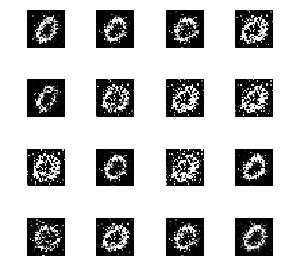

Epoch: 1600, [Discriminator :: Loss: 0.09978426], [ Generator :: Loss: 8.839916]


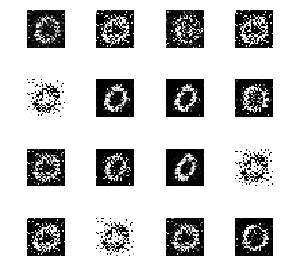

Epoch: 1700, [Discriminator :: Loss: 0.010022847], [ Generator :: Loss: 13.992368]


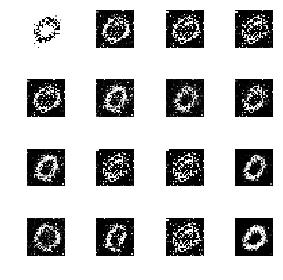

Epoch: 1800, [Discriminator :: Loss: 0.35606134], [ Generator :: Loss: 7.1056347]


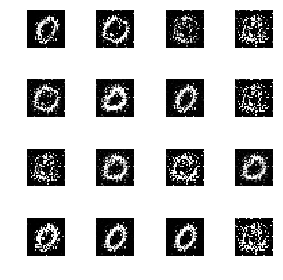

Epoch: 1900, [Discriminator :: Loss: 0.21957392], [ Generator :: Loss: 3.4777024]


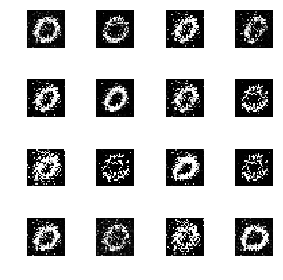

Epoch: 2000, [Discriminator :: Loss: 0.16767746], [ Generator :: Loss: 5.552189]


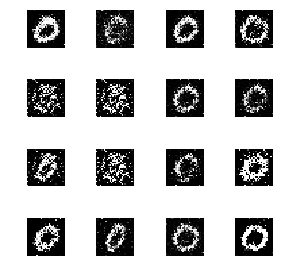

Epoch: 2100, [Discriminator :: Loss: 0.121295534], [ Generator :: Loss: 4.482173]


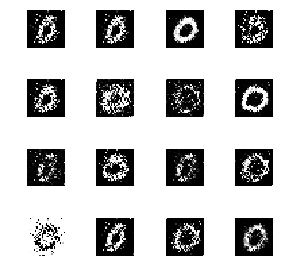

Epoch: 2200, [Discriminator :: Loss: 0.21382816], [ Generator :: Loss: 4.3712115]


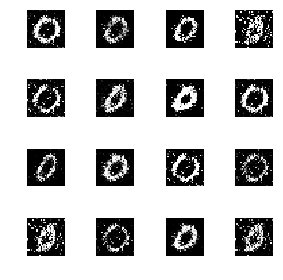

Epoch: 2300, [Discriminator :: Loss: 0.42521688], [ Generator :: Loss: 6.242751]


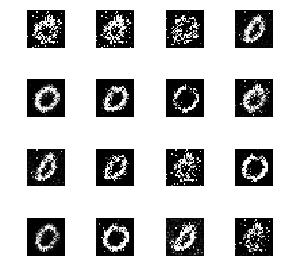

Epoch: 2400, [Discriminator :: Loss: 0.19681561], [ Generator :: Loss: 5.062502]


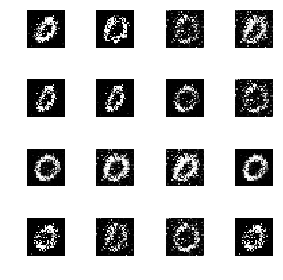

Epoch: 2500, [Discriminator :: Loss: 0.15648456], [ Generator :: Loss: 4.6026344]


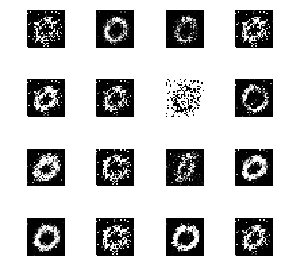

Epoch: 2600, [Discriminator :: Loss: 0.39467818], [ Generator :: Loss: 2.7038336]


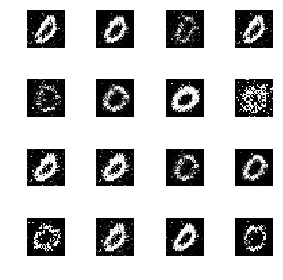

Epoch: 2700, [Discriminator :: Loss: 0.49299097], [ Generator :: Loss: 10.036173]


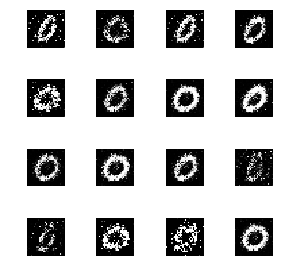

Epoch: 2800, [Discriminator :: Loss: 0.10931926], [ Generator :: Loss: 6.5879393]


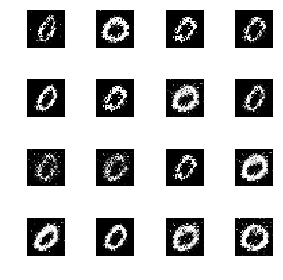

Epoch: 2900, [Discriminator :: Loss: 0.39531863], [ Generator :: Loss: 3.4003239]


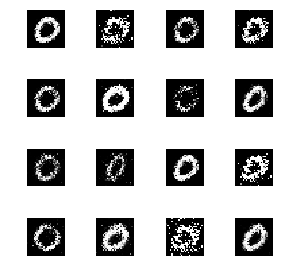

Epoch: 3000, [Discriminator :: Loss: 0.2934152], [ Generator :: Loss: 3.526123]


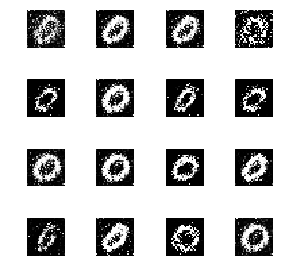

Epoch: 3100, [Discriminator :: Loss: 0.20368926], [ Generator :: Loss: 3.1124876]


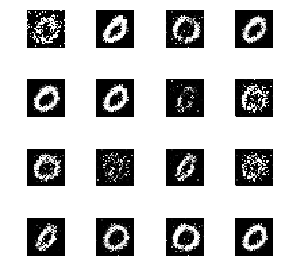

Epoch: 3200, [Discriminator :: Loss: 0.15234645], [ Generator :: Loss: 5.7326736]


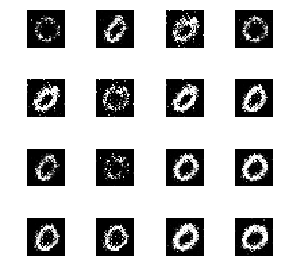

Epoch: 3300, [Discriminator :: Loss: 0.15058917], [ Generator :: Loss: 1.5643272]


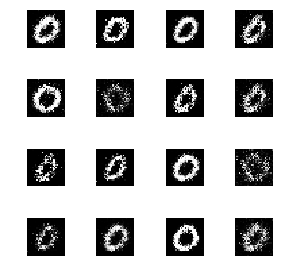

Epoch: 3400, [Discriminator :: Loss: 0.3778865], [ Generator :: Loss: 5.2391496]


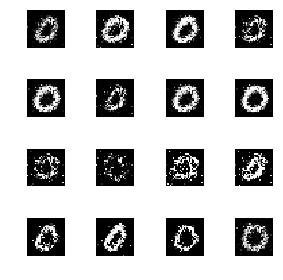

Epoch: 3500, [Discriminator :: Loss: 0.23996839], [ Generator :: Loss: 4.85775]


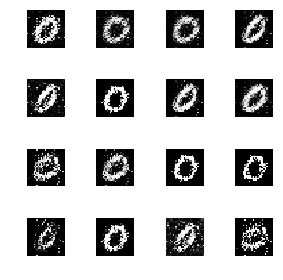

Epoch: 3600, [Discriminator :: Loss: 0.4047418], [ Generator :: Loss: 3.8804173]


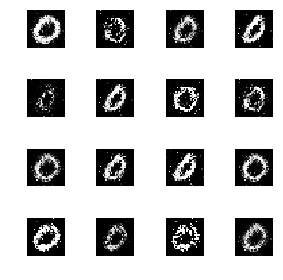

Epoch: 3700, [Discriminator :: Loss: 0.64084804], [ Generator :: Loss: 1.2702938]


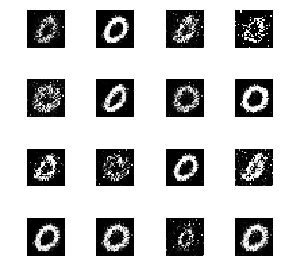

Epoch: 3800, [Discriminator :: Loss: 0.3735435], [ Generator :: Loss: 2.9205027]


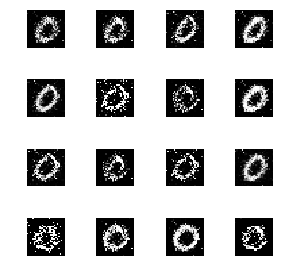

Epoch: 3900, [Discriminator :: Loss: 0.3540392], [ Generator :: Loss: 3.1787968]


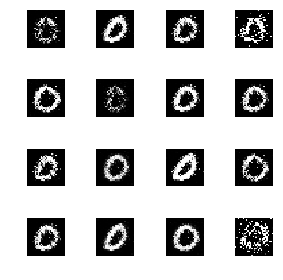

Epoch: 4000, [Discriminator :: Loss: 0.296413], [ Generator :: Loss: 4.9652233]


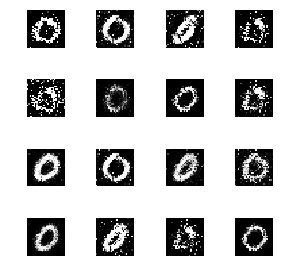

Epoch: 4100, [Discriminator :: Loss: 0.4186433], [ Generator :: Loss: 4.6059113]


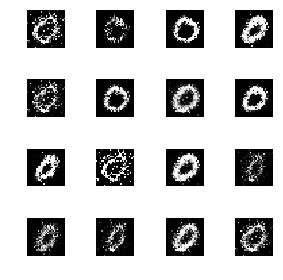

Epoch: 4200, [Discriminator :: Loss: 0.53587216], [ Generator :: Loss: 3.961948]


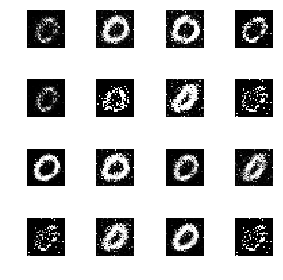

Epoch: 4300, [Discriminator :: Loss: 0.22608323], [ Generator :: Loss: 4.4838905]


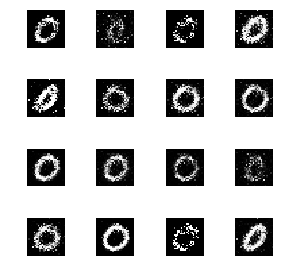

Epoch: 4400, [Discriminator :: Loss: 0.42311186], [ Generator :: Loss: 3.5328007]


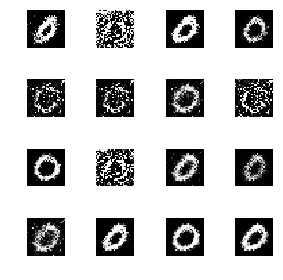

Epoch: 4500, [Discriminator :: Loss: 0.2638288], [ Generator :: Loss: 2.917472]


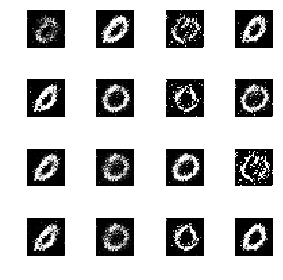

Epoch: 4600, [Discriminator :: Loss: 0.4810986], [ Generator :: Loss: 2.8874474]


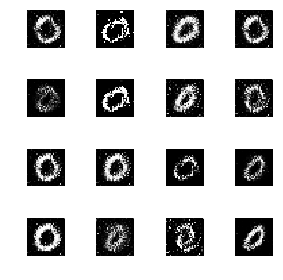

Epoch: 4700, [Discriminator :: Loss: 1.0608155], [ Generator :: Loss: 1.390279]


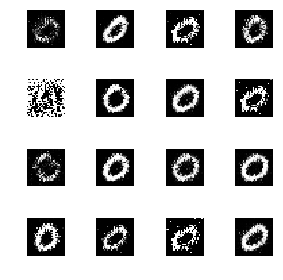

Epoch: 4800, [Discriminator :: Loss: 0.41289106], [ Generator :: Loss: 1.8558106]


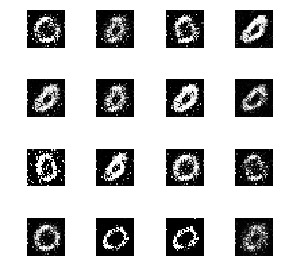

Epoch: 4900, [Discriminator :: Loss: 0.6680111], [ Generator :: Loss: 1.408301]


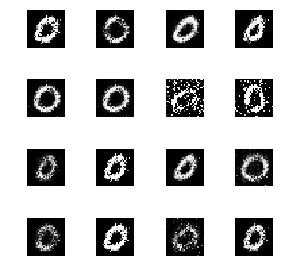

In [0]:
trainer.train()

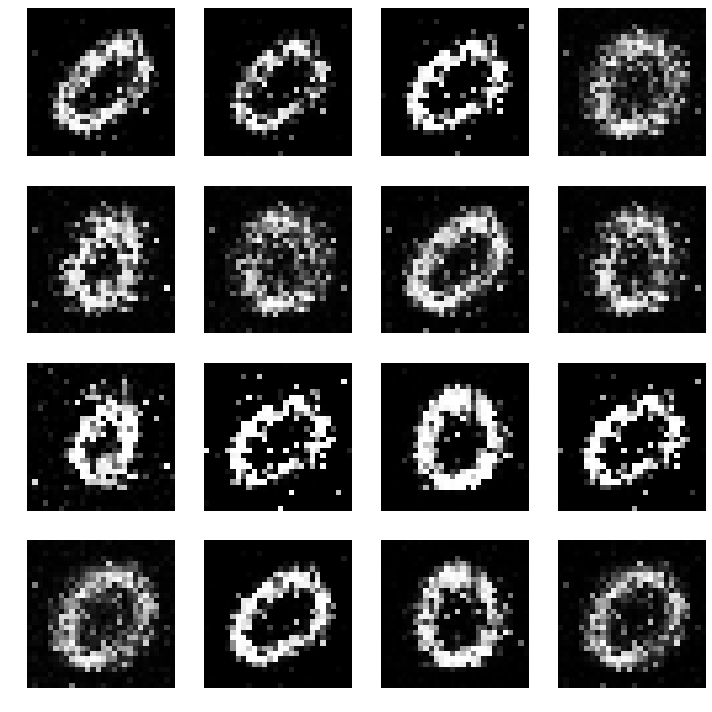

In [0]:
noise = trainer.sample_latent_space(16)
images = trainer.generator.Generator.predict(noise)

plt.figure(figsize=(10,10))
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [28,28])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()
        